In this notebook you will use the CIFAR10 dataset. It can be a bit long to download. **So start by downloading the dataset**.

**Objectives:**
- How to build and train a convolutional neural network
- Colored images classification with CIFAR-10
- Convolutional Networks (with pooling, batch-norm)

**Reminder on notebook:**
This notebook is a template of what could be explored. You can follow it or explore and experiment additional things. Use the notebook to add your comments, figures, .... You can remove and reorganize it as you wish.

In [1]:
# math, numpy and plot
import numpy as np
import math
import matplotlib
import matplotlib.pyplot as plt
# torch
import torch as th
import torch.autograd as autograd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# Dataset: CIFAR-10

First the dataset !  For images in pytorch, we expect the dataset to be a Tensor with 4 dimensions $(N,C,H,W)$ with :
- N the batch dimension, *i.e* the number of images
- C the number of input channels, here it is 3
- H the height or number of rows of each image
- W the width  or number of columns of each image




To experiment image classification on a coloured image, we can use the CIFAR-10 dataset.
You can find more details for instance on this page: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html. We can download the dataset and handle it with a dataloader.  

With this example we will use a **dataset** via a **dataloader**.  This is a convenient tool to handle datasets with efficient iterators. There is a [tutorial here](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html). But for the moment, you can just follow the next cells.

In [2]:
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


alltrainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


To be faster in the experiments, we can use a subset of the data with only N=10000 images.
    

In [3]:
N = 10000
trainset = th.utils.data.Subset(alltrainset, range(N))


And then plug a dataloader on the dataset for an easy iteration over it.

In [4]:
print(len(trainset))
print(len(testset))


10000
10000


In [5]:
batch_size = 400

trainloader = th.utils.data.DataLoader(trainset, 
                                       batch_size=batch_size,
                                          shuffle=True)
testloader = th.utils.data.DataLoader(testset, 
                                      batch_size=batch_size,
                                        shuffle=False)

## Look at some images

In [6]:
def imshow(img,small=True):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    fs = None
    if small:
        fs = (2,2)
    else:
        fs = (16,16)
    fig , ax= plt.subplots(figsize=fs)
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


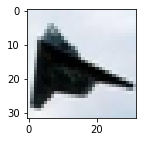

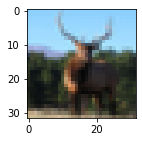

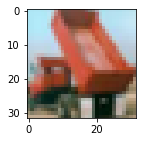

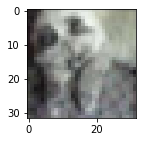

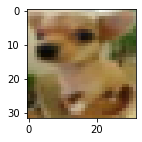

In [7]:
for i in np.random.randint(0,N,5):
    imshow(trainset[i][0])

torch.Size([3, 32, 32])
torch.Size([32, 32])


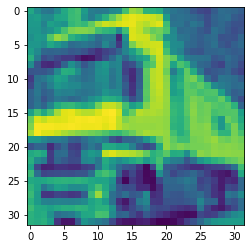

torch.Size([32, 32])


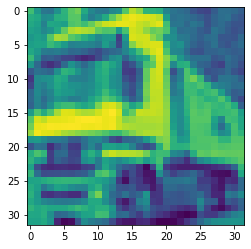

torch.Size([32, 32])


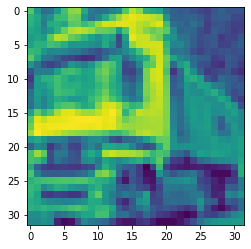

In [19]:
im = trainset[1][0]
print(im.shape)
for i in range(3):
    imr = im[i]
    print(imr.shape)
    plt.imshow(imr)
    plt.show()


## Training a simple model



**TODO**:
- Create a convolutional model with 32 output channels, kernel_size=(7,7),stride=(2,2), padding=(3,3), and bias=False. A Maxpooling and a linear classifier can follow this convolution part.
- Train this model on the trainset.
- Then write two functions, one to train a model and the other to compute the validation score.


In [54]:
conv = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=7,
                 stride=2,padding=3)
im = trainset[1][0].unsqueeze(0)
label = trainset[1][1]
out = conv(im)
print(im.shape, out.shape)

torch.Size([1, 3, 32, 32]) torch.Size([1, 32, 16, 16])


In [55]:
maxp = nn.MaxPool2d(kernel_size=2,stride=2)
outp = maxp(out)
print(outp.shape)

torch.Size([1, 32, 8, 8])


In [57]:
flat = nn.Flatten(1,-1)
outf = flat(outp)
print(outf.shape)

torch.Size([1, 2048])


In [59]:
lin = nn.Linear(2048,10)
lin(outf).shape

torch.Size([1, 10])

In [60]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3,out_channels=32,
              kernel_size=7, stride=2,padding=3),
    nn.MaxPool2d(2,2), 
    nn.Flatten(1,-1),
    nn.Linear(2048,10)
)


And the classifier ! 

In [61]:
model(im)


tensor([[-0.3589, -0.0651, -0.0804,  0.0576, -0.4506,  0.1314, -0.1530,  0.0855,
          0.1581, -0.1162]], grad_fn=<AddmmBackward0>)

In [65]:
def validation_score(model, dsetloader, device):
    criterion = nn.CrossEntropyLoss().to(device)
    correct = 0
    total = 0
    loss = 0
    with th.no_grad():
        for images, labels in dsetloader:
            images , labels = images.to(device) , labels.to(device)
            outputs = model(images)
            _, predicted = th.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            loss += criterion(outputs, labels)
    return correct, total, loss


In [66]:
validation_score(model,testloader,'cpu')

(1283, 10000, tensor(57.9446))

In [67]:
def trainer(model, trainsetloader, validsetloader, 
            lr=1e-3, 
            nepoch=10, device = 'cpu'):
    """This function trains
    - a pytorch model
    - on a train data set given its dataloader (trainsetloader)
    - after each epoch the validation score is computed (validsetloader)
    - lr = the initial learning rate of Adam
    - nepoch : the number of epochs for training
    """
    loss_fn = nn.CrossEntropyLoss().to(device)
    optimizer= th.optim.Adam(model.parameters(), lr=lr)
    Nepochs = nepoch # number of epochs
    Nprint  = 1  # frequence of print
    for epoch in range(Nepochs):
        total=0.
        model.train()
        for images , labels in trainloader:
            images , labels = images.to(device) , labels.to(device)
            # (re-)Init. the gradients of all the parameters
            optimizer.zero_grad()
            # inference with the model (build the computational graph)
            prediction = model(images)
            # Compute the loss function given the prediction and the supervision
            loss = loss_fn(prediction, labels)
            # Go backward through the computational graph
            loss.backward()
            # Make an optimization step
            optimizer.step()
            total+=loss
        model.eval()
        good , T , l = validation_score(model, testloader,device)
        print(epoch,total.item(), good*100/T)


In [68]:
device = 'cpu'
if th.cuda.is_available():
    device = th.device('cuda')  
trainer(model,trainloader,testloader,device=device)

0 48.966793060302734 38.19
1 42.42107391357422 42.65
2 39.52092742919922 44.26
3 37.54568099975586 45.97
4 35.93440628051758 48.32
5 34.335201263427734 49.46
6 33.03007888793945 50.45
7 32.103179931640625 51.15
8 31.292348861694336 50.77
9 30.330236434936523 52.43
10 29.465200424194336 51.92
11 28.833593368530273 52.57
12 28.217382431030273 53.62
13 27.57200050354004 53.77
14 26.95987892150879 53.57
15 26.3946475982666 54.23
16 25.92937469482422 54.31
17 25.467449188232422 54.22
18 25.145044326782227 55.33
19 24.591402053833008 54.37
20 24.504167556762695 55.26
21 23.843021392822266 55.26
22 23.42469024658203 55.21
23 23.253480911254883 55.49
24 22.682659149169922 55.33


KeyboardInterrupt: 

# More convolution

- Try to add a Batchnorm Layer
- Try a network with more progressive convolutions and pooling.